# MovieLens
## Goals
This project aims to compare different approaches to recommendation.
Each model tested allows to predict a rating for any movie and any user,
as longs as they have enough past ratings recorded.

## Data set
The data set contains ratings of movies by users, in the form of records `(rating, movieId, userId)`.
It is available in two sizes: `~100k` ratings and `~25m` ratings. These ratings are distributed among
`~42k` different movies and are given by `~260k` users. The data is very sparse with an average of TODO ratings per user and TODO ratings per movie. The dimensionality and sparsity (TODO % non-zero entries) of data requires careful treatment as naive operations on dense matrices would easily exhaust available memory.

## Algorithms used
1. **Item-item** Collaborative Filtering
This technique tries to predict a rating

TODO
- details of implementation for each Algorithms
- commentary on the results I got, why, etc.
- some conclusions
- maybe movie genre prediction


In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as sa
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import util

def load_data(size='small', test_size=0.3):
    ratings = util.read_files(size=size)[0]
    movie_counts = ratings.groupby('movieId').count()
    good_movies = set(movie_counts[movie_counts['userId'] > 20].index)
    # print(len(good_movies))
    ratings = ratings[ratings.movieId.isin(good_movies)]
    indices = np.unique(ratings['movieId'].values, return_inverse=True)[1]
    ratings['movieId'] = indices.astype('int32')
    return train_test_split(ratings, test_size=test_size)

# Item-item collaborative filtering
First precompute similarity matrix between all items
using cosine distance between rows of utility (`item x user`) matrix

Then predict unknown score for given `user` and `movie` by taking
weighted average of all ratings of this user

In [3]:
def calculate_item_item_similarity(ratings):
    """
    Calculate matrix of cosine distances between movies
    treated as vectors of ratings 
    """
    # Calculate the dot-products of ratings for all movies
    # Use sparse matrix for calculation to accomodate large data-set (~260k users, ~53k movies)
    # Storing results as dense matrix, allows us to use in-place operations
    # and provides faster indexing
    ii_similarity = coo_matrix(
        (ratings['rating'], (ratings['movieId'], ratings['userId']))
        ).tocsr()
    ii_similarity = ii_similarity.dot(ii_similarity.transpose()).toarray()
    
    d = 1 / np.sqrt(ii_similarity.diagonal())
    ii_similarity *= d.reshape((-1, 1))
    ii_similarity *= d.reshape((1, -1))
    return ii_similarity

In [4]:
def predict(user, movie, ii_similarity, ratings, user_ratings):
    """
    Predict rating of movie by user by calculating weighted average
    of ratings given by this user to other movies
    """
    other = ratings.iloc[user_ratings[user]]
    similarities = ii_similarity[movie, other['movieId']]
    tmp = similarities * other['rating']
    tmp = np.sum(tmp) / similarities.sum()
    return tmp

Asses rating prediction by calculating RMSE (Root Mean Square Error)

In [10]:
err_ii = []

for it in range(10):
    train, test = load_data(test_size=0.01)
    ii_similarity = calculate_item_item_similarity(train)
    user_ratings = train.groupby('userId').indices
    s = 0
    num_samples = len(test.index)
    for r in test.itertuples():
        p = predict(r.userId, r.movieId, ii_similarity, train, user_ratings)
        s += np.float64((p - r.rating) ** 2)
    s /= num_samples
    s = np.sqrt(s)
    err_ii.append(s)
    print(f'Done iter {it}')

Done iter 0
Done iter 1
Done iter 2
Done iter 3
Done iter 4
Done iter 5
Done iter 6
Done iter 7
Done iter 8
Done iter 9


In [11]:
print(f'Item-item CF error: {np.mean(err_ii)}')

Item-item CF error: 0.8880669254996322


# K-nearest neighbours
Find k most similar movies rated by a given user
and use average of their ratings.

In [ ]:
def predict_knn(user, movie, k, ii_similarity, ratings, user_ratings):
    """
    Predict rating of movie by user by calculating average
    of ratings given by this user to k most similar movies
    """
    other = ratings.iloc[user_ratings[user]].copy()
    other['sim'] = ii_similarity[movie, other['movieId']]
    k = min(k, len(other.index))
    tmp = other.sort_values(by='sim', ascending=False).head(k)['rating'].mean()
    return tmp

In [12]:
err_knn = []
for it in range(10):
    train, test = load_data(test_size=0.01)
    ii_similarity = calculate_item_item_similarity(train)
    user_ratings = train.groupby('userId').indices
    for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]:
        s = 0
        num_samples = len(test.index)
        for r in test.itertuples():
            p = predict_knn(r.userId, r.movieId, k, ii_similarity, train, user_ratings)
            s += np.float64((p - r.rating) ** 2)
        s /= num_samples
        s = np.sqrt(s)
        err_knn.append({ 'k': k, 'err': s, 'it': it })
    print(f'Done iter {it}')

err_knn = pd.DataFrame(err_knn)

Done iter 0
Done iter 1
Done iter 2
Done iter 3
Done iter 4
Done iter 5
Done iter 6
Done iter 7
Done iter 8
Done iter 9


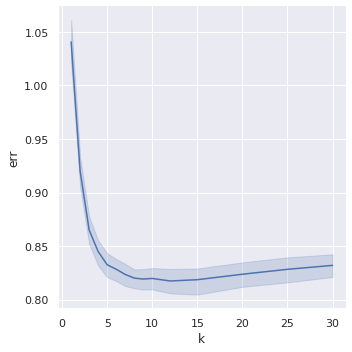

In [20]:
sns.relplot(data=err_knn, x='k', y='err', kind='line')

# Singular Value Decomposition
Factorize the utility matrix using SVD. This allows us to extract latent features
and reduce the dimensionality of the problem. Predict the rating by reconstructing
entries of utility matrix.

Entries in each row are normalized by average rating for a given user.
This allows us to keep the matrix sparse.

In [18]:
def predict(user, movie, user_mean, u, vt):
    return user_mean[user] + u[user, :] @ vt[:, movie]

err_svd = []

for it in range(10):
    ratings, test = load_data(size='small', test_size=0.1)
    user_mean = ratings.groupby('userId')['rating'].mean()
    means = user_mean.loc[ratings['userId'].array].values
    ratings['rating'] = ratings['rating'] - means
    utility = coo_matrix(
            (ratings['rating'], (ratings['userId'], ratings['movieId']))
            ).tocsr()
    for k in [4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 50, 100]:
        u, s, vt = sa.svds(utility, k=k)
        u = u @ np.diag(s)
        s = 0
        num_samples = len(test.index)
        for r in test.itertuples():
            p = predict(r.userId, r.movieId, user_mean, u, vt)
            s += np.float64((p - r.rating) ** 2)
        s /= num_samples
        s = np.sqrt(s)
        err_svd.append({ 'k': k, 'err': s, 'it': it })
    print(f'Done iter {it}')

err_svd = pd.DataFrame(err_svd)

Done iter 0
Done iter 1
Done iter 2
Done iter 3
Done iter 4
Done iter 5
Done iter 6
Done iter 7
Done iter 8
Done iter 9


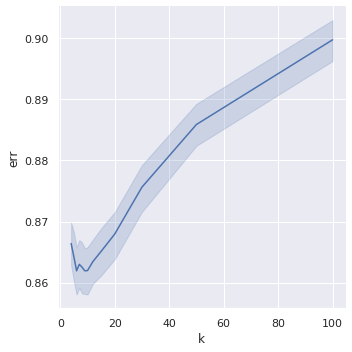

In [19]:
sns.relplot(data=err_svd, x='k', y='err', kind='line')